# Исследование объявлений о продаже квартир

На основе архива объявлений из Яндекс.Недвижимость о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет проведено исследование для определения параметров для автоматизированной системы: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

В данных присутствуют пропуски

Столбцы 
- *parks_around3000*
- *parks_nearest*
- *ponds_around3000*
- *ponds_nearest*

с картографическими данными , сгенерированными автоматически содержат много пропусков, 
т.к. эти данные мы никак не будем использовать в анализе удалим их из таблицы. 


In [3]:
df = df.drop(columns=['parks_around3000', 'parks_nearest','ponds_around3000','ponds_nearest','airports_nearest'])
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'cityCenters_nearest', 'days_exposition'],
      dtype='object')

Переименуем столбцы, чтобы придерживаться правила "Snake case" в наименовании столбцов

In [4]:
df = df.rename(columns={"cityCenters_nearest": "city_сenters_nearest"})
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'city_сenters_nearest', 'days_exposition'],
      dtype='object')

Описание данных
- balcony — число балконов
- ceiling_height — высота потолков (м)
- city_сenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

Пропуски в столбцах 
- ceiling_height - высота потолков, 
- floors_total - всего этажей 
- living_area - жилая площадь, 
- is_apartment - апартаменты, 
- kitchen_area - площадь кухни, 
- balcony - число балконов , 
- locality_name - название населенного пункта, 
- city_сenters_nearest - расстояние до центра города,
- days_exposition

Сначала проверим есть ли в данных дублирующиеся строки

In [5]:
df.duplicated().sum()

0

### Вывод

Данные содержат много пропусков. Столбцы, которые были заполнены автоматически и имеют пропуски, и не будут использоваться при анализе для решения поставленных задач, было решено исключить. По остальным столбцам требуется более детальный анализ.

## Предобработка данных

### Обработка пропусков в столбце *ceiling_height*

In [6]:
# функция для исследования пропусков в столбце
def review_na_column(column):
    percent_na = df[column].isna().mean()
    print(f'В столбце {column} {percent_na:.1%} пропусков.')
    print(f"Рассмотрим первые 10 строк, содержащие пропуски:")
    display(df.loc[df[column].isna()].head(10))
    
    print(f'Статистика по столбцу {column}')
    print(df[column].describe())
    
    print(f"Диаграмма размаха")
    df.boxplot(column=[column])
    


В столбце ceiling_height 38.8% пропусков.
Рассмотрим первые 10 строк, содержащие пропуски:


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,city_сenters_nearest,days_exposition
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,18603.0,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,13933.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,6800.0,424.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,19143.0,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,11634.0,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,189.0
11,9,3300000.0,44.00,2018-08-27T00:00:00,2,NaN,5.0,31.00,4,False,False,False,6.00,1.0,Ломоносов,51677.0,7.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,NaN,False,False,9.00,0.0,Сертолово,NaN,90.0
14,1,4400000.0,36.00,2016-06-23T00:00:00,1,NaN,6.0,17.00,1,NaN,False,False,8.00,0.0,Пушкин,30759.0,203.0


Статистика по столбцу ceiling_height
count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64
Диаграмма размаха


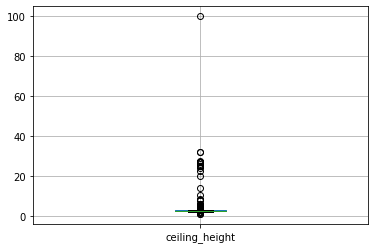

In [7]:
review_na_column('ceiling_height')

- В данных большой процент пропусков, этот столбец потребуется для исследований, поэтому требуется более детальный анализ пропусков.
- Если посмотреть на минимальное и максимальное значение, то можно предположить, что в данных присутствуют выбросы, при этом среднее значение и медиана, приблизительно равны. 
- Посмотрим распредление с помощью boxplot

Высота 100 очевидный выброс в данных, посмотрим на график без учета него

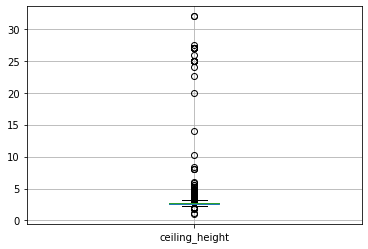

In [8]:
df.query("ceiling_height < 100").boxplot(column=['ceiling_height'])

Посмотрим на распределение с некоторой отсечкой выбросов:

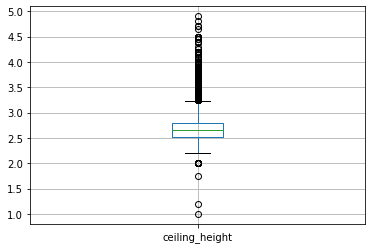

In [9]:
df.query("ceiling_height < 5").boxplot(column=['ceiling_height'])

Интересно рассмотреть скопление выбросов в диапазоне от 20 до 30, вероятно, что здесь могла быть опечатка в данных

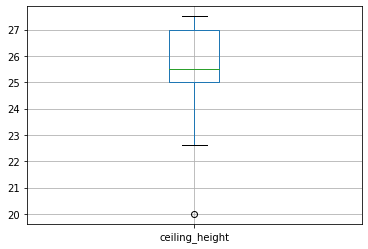

In [10]:
df.query("ceiling_height < 30 and ceiling_height >= 20").boxplot(column=['ceiling_height'])

Распределение очень похоже на распределение по всему столбцу. Межквартильный размах от 2,5 до 2,7. Исходя из этого предположения заменим значения в диапазоне от 20 до 30, разделив на 10

In [11]:
df.loc[(df["ceiling_height"] < 30) & (df['ceiling_height'] >= 20),'ceiling_height'].apply(lambda x: x/10)
df.loc[(df["ceiling_height"] < 30) & (df['ceiling_height'] >= 20),'ceiling_height'].count()

20

Посмотрим, какая корреляция значений столбца *ceiling_height* с остальными столбцами

In [12]:
display(df.loc[df['ceiling_height'].notna()].corr()['ceiling_height'].sort_values(ascending=False))

ceiling_height          1.000000
total_area              0.095490
living_area             0.090650
kitchen_area            0.087641
last_price              0.085430
rooms                   0.054457
open_plan               0.042777
balcony                 0.040523
days_exposition         0.019091
studio                  0.001674
total_images           -0.001987
floor                  -0.011798
floors_total           -0.028732
city_сenters_nearest   -0.091689
Name: ceiling_height, dtype: float64

Существенной корреляции не обнаружено, но наибольшая зависимость от столбцов *total_area* , *city_сenters_nearest*

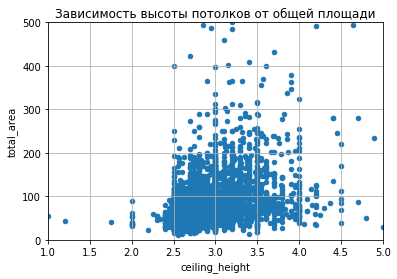

In [13]:
df.plot(x='ceiling_height', y='total_area', kind='scatter', xlim = (1,5), ylim = (0,500), grid = True, title='Зависимость высоты потолков от общей площади')

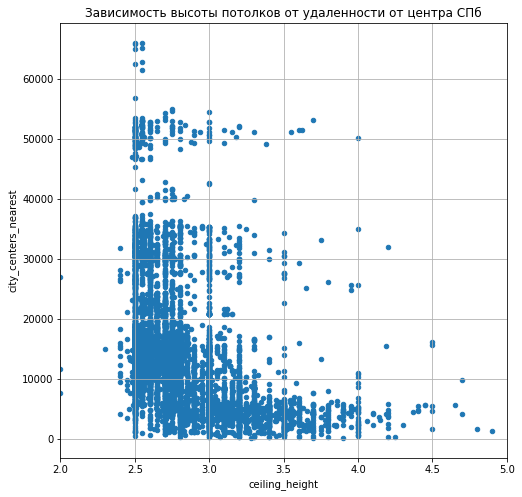

In [14]:
df.plot(x='ceiling_height', y='city_сenters_nearest', kind='scatter', xlim = (2,5),figsize=(8,8),grid = True,title='Зависимость высоты потолков от удаленности от центра СПб')

На графике видна, тенденция изменения разброса в зависимости от удаленности. Сделаем несколько срезов по удаленности от центра.

In [15]:
df['city_сenters_nearest_cut'] = pd.cut(df['city_сenters_nearest'],[0,5000,10000,12000,15000,20000,df['city_сenters_nearest'].max()])
display(df.groupby(by='city_сenters_nearest_cut')['ceiling_height'].agg(['median','count']))

,median,count
city_сenters_nearest_cut,,
"(0.0, 5000.0]",3.1,1391
"(5000.0, 10000.0]",2.8,1942
"(10000.0, 12000.0]",2.6,1495
"(12000.0, 15000.0]",2.6,2886
"(15000.0, 20000.0]",2.6,2237
"(20000.0, 65968.0]",2.6,1609


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


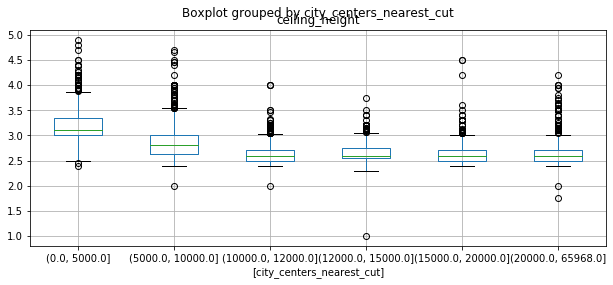

In [16]:
df.query("ceiling_height < 5").boxplot(column=['ceiling_height'], by=['city_сenters_nearest_cut'], figsize = (10,4))

Видим что в центре Санкт-Петербурга, медианное значение высоты потолков и межквартильных размах отличается, от более удаленных территорий. Так же стоит отметить тенденцию, чем дальше от центра в том числе и за городом медианное значение выранивается и равно 2.6 Заменим пропуски по *ceiling_height* медианами по срезам. Остальное заполним общей медианой по столбцу

In [17]:
df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby(by=['city_сenters_nearest_cut'])['ceiling_height'].transform('median'))
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
df['ceiling_height'].isna().sum()

0

**Обработка пропусков в столбце *floors_total***

Так как данный столбец потребуется для дальнейшего анализа, проанализируем на сколько закономерны пропуски.

Всего пропусков менее 1%. И данный столбец c дискретными значениями в дальнейшем мы будем использовать для категоризации, здесь точность данных важна. Мы не сможем их заполнить опираясь на другие данные в таблице, если бы был известен адрес или точные координаты дома, то заполнить можно было бы. Поэтому, чтобы отметить, что в данных значениях были пропуски, заполним их 0. В дальнейшем при анализе данного столбца, эти строки будут исключаться.

In [18]:
df['floors_total'].isna().mean()

0.0036288450989493226

In [19]:
df['floors_total'] = df['floors_total'].fillna(0)
df['floors_total'].isna().sum()

0

**Обработка пропусков в столбце *living_area***

В столбце living_area 8.0% пропусков.
Рассмотрим первые 10 строк, содержащие пропуски:


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,city_сenters_nearest,days_exposition,city_сenters_nearest_cut
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.8,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,6800.0,424.0,"(5000.0, 10000.0]"
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.6,24.0,NaN,22,NaN,False,False,18.9,2.0,Санкт-Петербург,11634.0,NaN,"(10000.0, 12000.0]"
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.6,9.0,NaN,2,NaN,False,False,NaN,NaN,Коммунар,NaN,63.0,NaN
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.5,5.0,NaN,1,NaN,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,196.0,NaN
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.6,22.0,NaN,3,NaN,False,False,NaN,1.0,Санкт-Петербург,11603.0,NaN,"(10000.0, 12000.0]"
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,2.6,13.0,NaN,13,NaN,False,False,NaN,NaN,Санкт-Петербург,14501.0,336.0,"(12000.0, 15000.0]"
60,3,2740000.0,35.0,2018-01-01T00:00:00,1,2.6,12.0,NaN,8,NaN,False,False,NaN,NaN,посёлок Мурино,NaN,11.0,NaN
81,9,10949000.0,68.0,2018-12-27T00:00:00,1,2.6,10.0,NaN,6,NaN,False,False,NaN,NaN,Санкт-Петербург,NaN,NaN,NaN
82,3,4500000.0,80.5,2018-01-15T00:00:00,3,2.6,25.0,NaN,16,NaN,False,False,NaN,NaN,посёлок Шушары,18217.0,60.0,"(15000.0, 20000.0]"
116,18,10999000.0,97.2,2017-11-13T00:00:00,3,2.5,16.0,NaN,16,NaN,False,False,18.3,5.0,Санкт-Петербург,21138.0,394.0,"(20000.0, 65968.0]"


Статистика по столбцу living_area
count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64
Диаграмма размаха


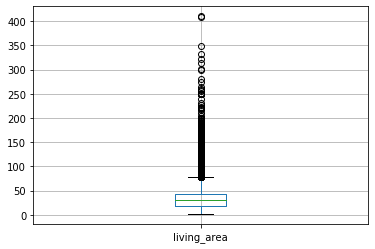

In [20]:
review_na_column('living_area')

Рассмотрим более детально распределение за пределами 1 квартиля

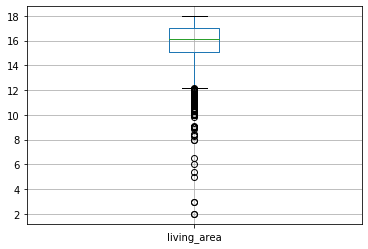

In [21]:
df.query('living_area < 18').boxplot(column=['living_area'])

Рассмотрим распределение за пределеами 3 квартиля

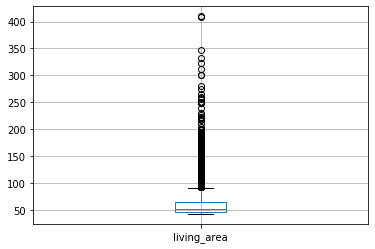

In [22]:
df.query('living_area >42').boxplot(column=['living_area'])

Для заполнения пропусков, посмотрим с какими столбцами больше всего коррелирует данные в столбце с жилой площадью и количеством комнат

In [23]:
display(df.loc[df['living_area'].notna()].corr()['living_area'].sort_values(ascending=False))

living_area             1.000000
total_area              0.939537
rooms                   0.845977
last_price              0.566492
kitchen_area            0.428674
days_exposition         0.142454
total_images            0.104780
ceiling_height          0.094933
balcony                 0.018849
open_plan              -0.033711
studio                 -0.056231
floor                  -0.097210
floors_total           -0.168260
city_сenters_nearest   -0.231368
Name: living_area, dtype: float64

Диаграмма рассеивания общей и жилой площади

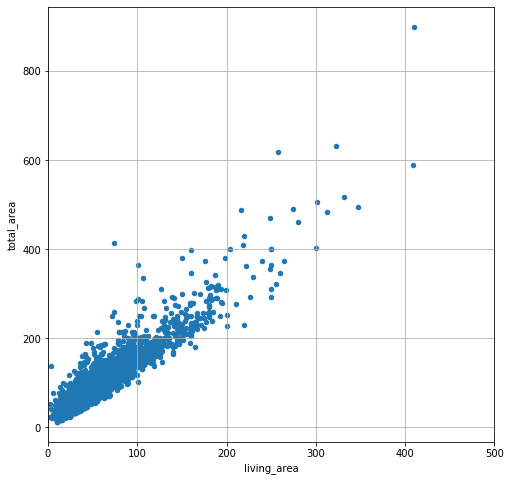

In [24]:
df.plot(x='living_area', y='total_area', kind='scatter', xlim = (0,500),figsize=(8,8),grid = True,title='')

Диаграмма рассеивания жилой площади в зависимости от количества комнат

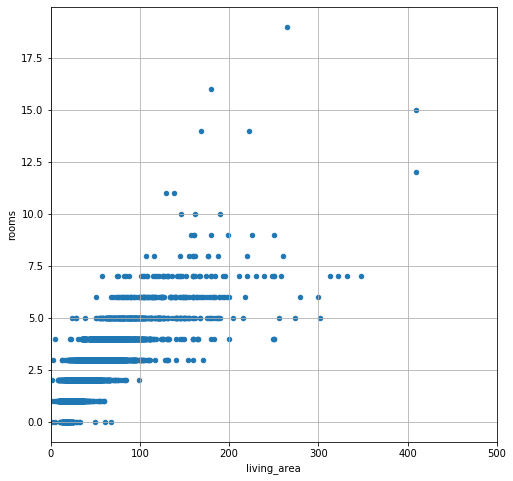

In [25]:
df.plot(x='living_area', y='rooms', kind='scatter', xlim = (0,500),figsize=(8,8),grid = True,title='')

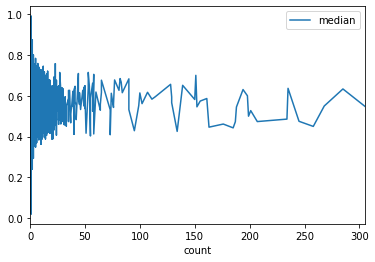

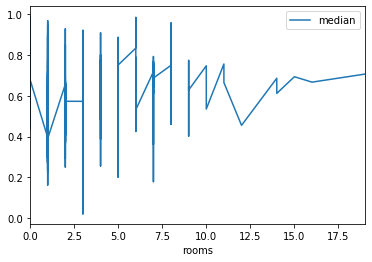

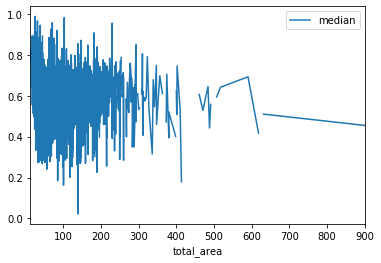

In [26]:
#столбец living_fraction хранит какую часть жилая площадь составляет от общей
df['living_fraction'] = df['living_area']/df['total_area']

#группировка по количеству комнат и общей площади с подсчетом количсетва и медианы по жилой площаде
data_living_area_med = df.groupby(by=['rooms','total_area'])['living_fraction'].agg(['median','count']).reset_index().sort_values('count', ascending = False)
data_living_area_med.sort_values('count').plot.line(x='count', y = 'median')
data_living_area_med.sort_values('rooms').plot.line(x='rooms', y = 'median')
data_living_area_med.sort_values('total_area').plot.line(x='total_area', y = 'median')


Посмотрим как распределен процент площади жилой от нежилой в срезе по количеству комнат и общим площадям

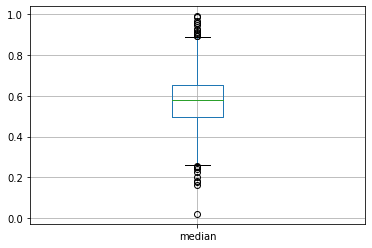

In [27]:
data_living_area_med.boxplot(column=['median'])

В среднем жилая площадь составляет приблизительно 60% от всей жилой площади.

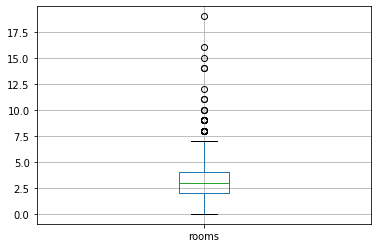

In [28]:
data_living_area_med.boxplot(column=['rooms'])

In [29]:
df['living_fraction'].isna().sum()

1903

Минимальное и максимальный диапазон по количеству комнат(0,7)

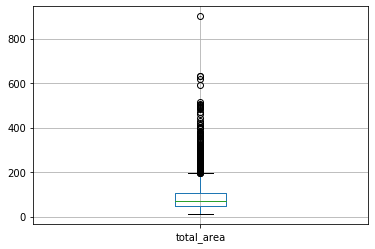

In [30]:
data_living_area_med.boxplot(column=['total_area'])

Редкие значения от 200. Рассмотрим диаграмму размаха процента жилой от не жилой площади в разрезе по количеству комнат в квартире.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


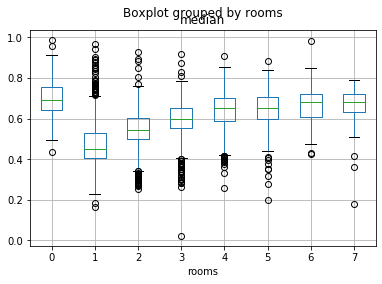

In [31]:
data_living_area_med.query('rooms<8').boxplot(column=['median'],by='rooms',)

In [32]:
data_living_area_med['median'].median()

0.5802728226652676

In [33]:
data_living_area_med.query('total_area < 200 and rooms<7')['median'].median()

0.5766262403528114

Предполагаем, что 0 комнат, это студии или квартиры свободной планировки. 
Для 0 комнат и комнат более 3, жилая площадь составляет 0.7
В то время как для 1 и 2, 3 комнатных квартир медианно, это значение примерно 0.55
При этом квартиры с 1,2,3 комнатами составляют 92% всех квартир.


In [34]:
data_living_area_med.query('total_area < 200 and rooms<4 and rooms>0')['median'].median()

0.5502205523496669

Распределение по количеству комнат в исходной таблице

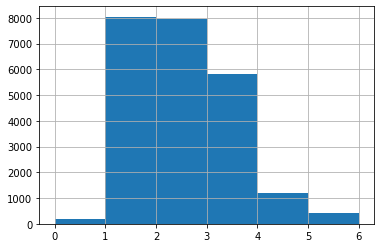

In [35]:
df['rooms'].hist(range=(0,7), bins=range(7))

In [36]:
df.isin(df.query('rooms < 4 and rooms > 0'))['rooms'].mean() 

0.9199122325836533

В связи со всеми выше выводами заполним жилую площадь для квартир с комнатами 1,2,3 из рассчета 55% общей

In [37]:
df['living_fraction'] = df.query('rooms < 4 and rooms > 0')['living_fraction'].fillna(0.55)

In [38]:
df['living_fraction'] = df['living_fraction'].fillna(0.7)
df['living_fraction'].isna().sum()

0

Заполним значения в столбце с жилой площадью

In [39]:
df['living_area'] = df['living_area'].fillna(df['total_area']*df['living_fraction'])
df['living_area'].isna().mean()

0.0

**Вывод:**
- Выявлена сильная зависимость между общей площадью и жилой площадью, поэтому для заполнения пропусков по данному столбцу, изначально было рассчитано среднее отношение жилой площади к нежилой. Для всех квартир это значение составило 55%
- Между количеством комнат и жилой площадью также сильная зависимость, поэтому мы рассмотрели отношение жилой к нежилой площади в срезе по количеству комнат в картире и выявили, что:
    - Для 0 комнат и комнат более 3, жилая площадь составляет 0.7
    - В то время как для 1 и 2, 3 комнатных квартир медианно, это значение примерно 0.55
    - При этом квартиры с 1,2,3 комнатами составляют 92% всех квартир.
- Для рассчета среднего отношения площадей, были исключены выбросы по общей площади квартир и по количеству комнат. Брали площади менее 200 и количество комнат не более 7

**Обработка пропусков в столбце *kitchen_area***

В столбце kitchen_area 9.6% пропусков.
Рассмотрим первые 10 строк, содержащие пропуски:


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,city_сenters_nearest,days_exposition,city_сenters_nearest_cut,living_fraction
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.8,14.0,87.450,9,NaN,False,False,NaN,0.0,Санкт-Петербург,6800.0,424.0,"(5000.0, 10000.0]",0.55
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.6,9.0,18.040,2,NaN,False,False,NaN,NaN,Коммунар,NaN,63.0,NaN,0.55
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.5,5.0,25.190,1,NaN,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,196.0,NaN,0.55
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.6,22.0,22.000,3,NaN,False,False,NaN,1.0,Санкт-Петербург,11603.0,NaN,"(10000.0, 12000.0]",0.55
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,2.6,13.0,25.575,13,NaN,False,False,NaN,NaN,Санкт-Петербург,14501.0,336.0,"(12000.0, 15000.0]",0.55
60,3,2740000.0,35.0,2018-01-01T00:00:00,1,2.6,12.0,19.250,8,NaN,False,False,NaN,NaN,посёлок Мурино,NaN,11.0,NaN,0.55
81,9,10949000.0,68.0,2018-12-27T00:00:00,1,2.6,10.0,37.400,6,NaN,False,False,NaN,NaN,Санкт-Петербург,NaN,NaN,NaN,0.55
82,3,4500000.0,80.5,2018-01-15T00:00:00,3,2.6,25.0,44.275,16,NaN,False,False,NaN,NaN,посёлок Шушары,18217.0,60.0,"(15000.0, 20000.0]",0.55
133,12,3150000.0,31.0,2018-03-23T00:00:00,1,2.6,25.0,17.050,6,NaN,False,False,NaN,NaN,посёлок Мурино,NaN,78.0,NaN,0.55
144,1,2450000.0,27.0,2017-03-30T00:00:00,0,2.6,24.0,15.500,2,NaN,True,False,NaN,2.0,посёлок Мурино,NaN,181.0,NaN,0.70


Статистика по столбцу kitchen_area
count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64
Диаграмма размаха


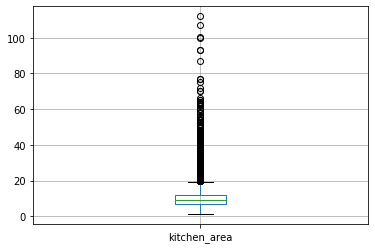

In [40]:
review_na_column('kitchen_area')

Распределение аномально больших площадей кухонь

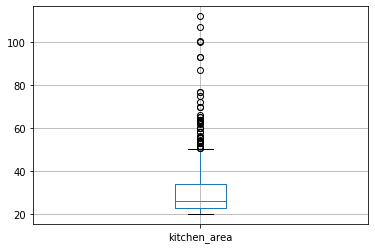

In [41]:
df.query('kitchen_area > 20').boxplot(column=['kitchen_area'])

Таблица корреляции от других столбцов

In [42]:
display(df.loc[df['kitchen_area'].notna()].corr()['kitchen_area'].sort_values(ascending=False))

kitchen_area            1.000000
total_area              0.609121
last_price              0.519869
living_area             0.436173
rooms                   0.269945
floors_total            0.161820
floor                   0.135531
total_images            0.104756
days_exposition         0.100586
balcony                 0.098634
ceiling_height          0.083744
city_сenters_nearest   -0.190049
living_fraction        -0.246566
studio                       NaN
open_plan                    NaN
Name: kitchen_area, dtype: float64

Диаграмма рассеивания

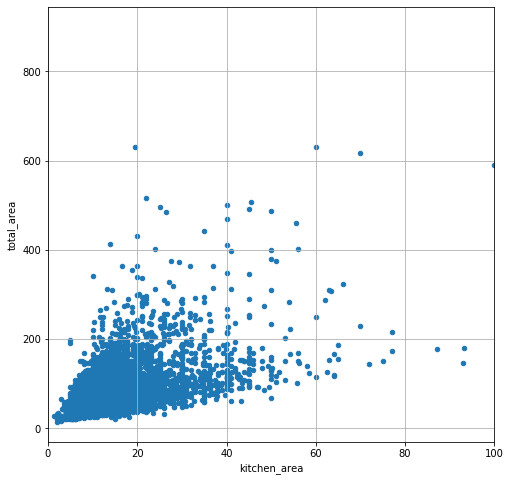

In [43]:
df.plot(x='kitchen_area', y='total_area', kind='scatter', xlim = (0,100),figsize=(8,8),grid = True,title='')

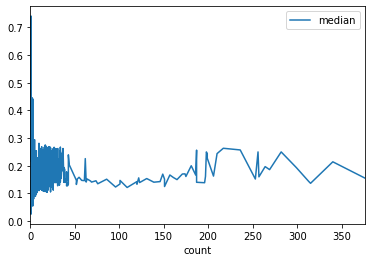

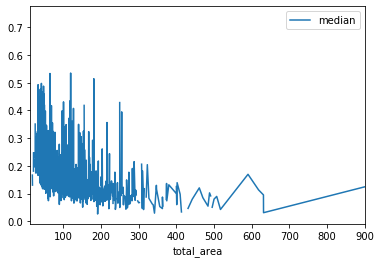

In [44]:
#рассчет отночения плоади кухни к общей площади
df['kitchen_fraction'] = df['kitchen_area']/df['total_area']

data_kitchen_area_med = df.groupby(by=['total_area'])['kitchen_fraction'].agg(['median','count']).reset_index().sort_values('count', ascending = False)
data_kitchen_area_med.sort_values('count').plot.line(x='count', y = 'median')
data_kitchen_area_med.sort_values('total_area').plot.line(x='total_area', y = 'median')


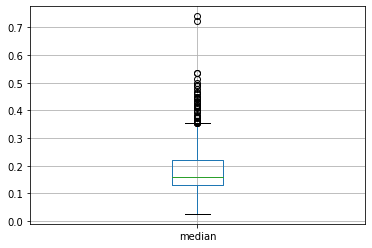

In [45]:
data_kitchen_area_med.boxplot(column=['median'])

In [46]:
data_kitchen_area_med['median'].median()

0.158974358974359

Наиболее частое медианное значение 15,8%, площадь кухни составляет от общей площади. Данным значением заполним пропуски в столбце 'kitchen_fraction'

In [47]:
df['kitchen_fraction'] = df['kitchen_fraction'].fillna(0.158)

Заполним пропуски в столбце с площадью кухни

In [48]:
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area']*df['kitchen_fraction'])
df['kitchen_area'].isna().mean()

0.0

**Обработка пропусков в столбце *is_apartment***

In [49]:
df['is_apartment'].isna().mean()

0.8829064517490189

In [50]:
display(df.loc[df['is_apartment'].isna()].head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,city_сenters_nearest,days_exposition,city_сenters_nearest_cut,living_fraction,kitchen_fraction
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.000,NaN,Санкт-Петербург,16028.0,NaN,"(15000.0, 20000.0]",0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.60,11.0,18.60,1,NaN,False,False,11.000,2.0,посёлок Шушары,18603.0,81.0,"(15000.0, 20000.0]",0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.60,5.0,34.30,4,NaN,False,False,8.300,0.0,Санкт-Петербург,13933.0,558.0,"(12000.0, 15000.0]",0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.80,14.0,87.45,9,NaN,False,False,25.122,0.0,Санкт-Петербург,6800.0,424.0,"(5000.0, 10000.0]",0.550000,0.158000
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.000,NaN,Санкт-Петербург,8098.0,121.0,"(5000.0, 10000.0]",0.320000,0.410000
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.60,12.0,14.40,5,NaN,False,False,9.100,NaN,городской посёлок Янино-1,NaN,55.0,NaN,0.473684,0.299342
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,2.60,26.0,10.60,6,NaN,False,False,14.400,1.0,посёлок Парголово,19143.0,155.0,"(15000.0, 20000.0]",0.284182,0.386059
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,2.60,24.0,39.38,22,NaN,False,False,18.900,2.0,Санкт-Петербург,11634.0,NaN,"(10000.0, 12000.0]",0.550000,0.263966
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.60,27.0,15.43,26,NaN,False,False,8.810,NaN,посёлок Мурино,NaN,189.0,NaN,0.465320,0.265682
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.500,2.0,Санкт-Петербург,15008.0,289.0,"(15000.0, 20000.0]",0.714754,0.106557


Если попробовать сейчас добавить объявление о недвижимости на ЯНедвижимость, то обязательным пунктом является выбор "Аппартаменты" или "Жилой фонд". Возможно ранее такой выбор бы не доступен или произошел технический сбой.
Данные в этом столбце нам в дальнейшем не пригодятся и они содержат 88% пропусков, данный столбец мы тоже удалим.

In [51]:
df = df.drop(columns=['is_apartment'])
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'studio', 'open_plan', 'kitchen_area', 'balcony', 'locality_name',
       'city_сenters_nearest', 'days_exposition', 'city_сenters_nearest_cut',
       'living_fraction', 'kitchen_fraction'],
      dtype='object')

**Обработка пропусков в столбце *locality_name***

In [52]:
df['locality_name'].isna().mean()

0.002067597788936242

In [53]:
df.groupby(by='locality_name')['city_сenters_nearest'].agg(['min','max','count']).sort_values('count',ascending = False)

,min,max,count
locality_name,,,
Санкт-Петербург,181.0,29493.0,15660
посёлок Шушары,17012.0,32079.0,436
Пушкин,24311.0,35610.0,368
Колпино,29436.0,37477.0,337
посёлок Парголово,17994.0,24415.0,327
...,...,...,...
деревня Пустынка,NaN,NaN,0
деревня Пудомяги,NaN,NaN,0
деревня Пикколово,NaN,NaN,0


Доля пропусков <1%,
Стоит отметить, что в столбцах 'city_сenters_nearest' указана именно удаленность от центра Санкт-Петербурга. 
Даже по удаленности до центра СПб, без точных координат, невозможно однозначно определить населенный пункт. Столбец 'locality_name', необходим для анализа, поэтому пропуски заполним значением "Неизвестно"

In [54]:
df['locality_name'] = df['locality_name'].fillna('Неизвестно')
df.query('locality_name=="Неизвестно"').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,city_сenters_nearest,days_exposition,city_сenters_nearest_cut,living_fraction,kitchen_fraction
1097,3,8600000.0,81.7,2016-04-15T00:00:00,3,3.55,5.0,50.8,2,False,False,8.8,0.0,Неизвестно,4258.0,147.0,"(0.0, 5000.0]",0.621787,0.107711
2033,6,5398000.0,80.0,2017-05-30T00:00:00,3,2.60,4.0,42.6,2,False,False,18.6,0.0,Неизвестно,NaN,34.0,NaN,0.532500,0.232500
2603,20,3351765.0,42.7,2015-09-20T00:00:00,1,2.60,24.0,15.6,3,False,False,10.7,0.0,Неизвестно,17369.0,276.0,"(15000.0, 20000.0]",0.365340,0.250585
2632,2,5130593.0,62.4,2015-10-11T00:00:00,2,2.60,24.0,33.1,21,False,False,8.2,0.0,Неизвестно,17369.0,256.0,"(15000.0, 20000.0]",0.530449,0.131410
3574,10,4200000.0,46.5,2016-05-28T00:00:00,2,2.80,5.0,30.8,5,False,False,6.5,0.0,Неизвестно,8127.0,45.0,"(5000.0, 10000.0]",0.662366,0.139785


**Обработка пропусков в столбце *balcony***

In [55]:
df['balcony'].isna().mean()

0.4860542638929913

Доля пропусков по столбцу 48%

In [56]:
df[df['balcony'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,city_сenters_nearest,days_exposition,city_сenters_nearest_cut,living_fraction,kitchen_fraction
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,False,25.00,NaN,Санкт-Петербург,16028.0,NaN,"(15000.0, 20000.0]",0.472222,0.231481
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,False,41.00,NaN,Санкт-Петербург,8098.0,121.0,"(5000.0, 10000.0]",0.320000,0.410000
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.60,12.0,14.40,5,False,False,9.10,NaN,городской посёлок Янино-1,NaN,55.0,NaN,0.473684,0.299342
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.60,27.0,15.43,26,False,False,8.81,NaN,посёлок Мурино,NaN,189.0,NaN,0.465320,0.265682
10,5,5050000.0,39.60,2017-11-16T00:00:00,1,2.67,12.0,20.30,3,False,False,8.50,NaN,Санкт-Петербург,13878.0,137.0,"(12000.0, 15000.0]",0.512626,0.214646


In [57]:
df['balcony'].value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

Предположим, что если по количеству балконов пропуск, то его нет.

In [58]:
df['balcony']= df['balcony'].fillna(0)

In [59]:
df[df['balcony'].isna()]['balcony'].sum()

0.0

**Обработка пропусков в столбце city_сenters_nearest**

Расстояние до центра нельзя заполнить по имеющимся данным, данные пропуски заменим на -1, чтобы в дальнейшейм эти строки исключить.

In [60]:
df['city_сenters_nearest'] = df['city_сenters_nearest'].fillna(-1)
df['city_сenters_nearest'].isna().sum()

0

**Изменение типов данных**

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 19 columns):
total_images                23699 non-null int64
last_price                  23699 non-null float64
total_area                  23699 non-null float64
first_day_exposition        23699 non-null object
rooms                       23699 non-null int64
ceiling_height              23699 non-null float64
floors_total                23699 non-null float64
living_area                 23699 non-null float64
floor                       23699 non-null int64
studio                      23699 non-null bool
open_plan                   23699 non-null bool
kitchen_area                23699 non-null float64
balcony                     23699 non-null float64
locality_name               23699 non-null object
city_сenters_nearest        23699 non-null float64
days_exposition             20518 non-null float64
city_сenters_nearest_cut    18180 non-null category
living_fraction             23699 non

Столбцы тербующие изменения типа данных:
- first_day_exposition
- floors_total
- balcony
- days_exposition
- last_price 

В столбце *first_day_exposition* сейчас определен тип данных object, т.к. там хранится дата размещения переведем данные в формат datetime64

In [62]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')
df['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]

В столбцах *floors_total*, *balcony*, *last_price* сейчас определен тип данных float64 по смыслу там должны быть целочисленные значения, поэтому переведем их в тип int64

In [63]:
df = df.astype({'floors_total':'int64',
                'balcony':int,
                'last_price':'int64'
               })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 19 columns):
total_images                23699 non-null int64
last_price                  23699 non-null int64
total_area                  23699 non-null float64
first_day_exposition        23699 non-null datetime64[ns]
rooms                       23699 non-null int64
ceiling_height              23699 non-null float64
floors_total                23699 non-null int64
living_area                 23699 non-null float64
floor                       23699 non-null int64
studio                      23699 non-null bool
open_plan                   23699 non-null bool
kitchen_area                23699 non-null float64
balcony                     23699 non-null int64
locality_name               23699 non-null object
city_сenters_nearest        23699 non-null float64
days_exposition             20518 non-null float64
city_сenters_nearest_cut    18180 non-null category
living_fraction             23699 n

**Вывод:**
- исходные данные содержали много пропусков
- часть пропусков невозможно было заполнить, из-за того что нет точных координат дома
- много пропусков по высоте потолков - 38.8%. При заполнении пропусков по высоте потолков опирались на средние значения с учётом удаленности от центра СПб, т.к. было выявлено, что в среднем более высокие потолки, ближе к центру СПб. В то время как после 10000 км от центра, во всех квартирах в среднем высота 2.6 уже независимо от расстояния до центра.
- обработали пропуски в столбцах "жилая площадь", "площадь кухни". При заполнении пропусков использовалось среднее отношение этих площадей к общей площади квартиры с учетом количества комнат в квартире.

## Расчёты и добавление результатов в таблицу

**Рассчет стоимости квадратного метра**

In [64]:
df['price_m_sq'] = df['last_price'] / df['total_area']
df['price_m_sq'] = df['price_m_sq'].map('{:.2f}'.format)
df[['last_price','total_area','price_m_sq',]]

,last_price,total_area,price_m_sq
0,13000000,108.00,120370.37
1,3350000,40.40,82920.79
2,5196000,56.00,92785.71
3,64900000,159.00,408176.10
4,10000000,100.00,100000.00
...,...,...,...
23694,9700000,133.81,72490.85
23695,3100000,59.00,52542.37
23696,2500000,56.70,44091.71
23697,11475000,76.75,149511.40


**Заполнение день недели, месяц и год публикации объявления**

In [65]:
df['day_of_week_exposition'] = df['first_day_exposition'].dt.dayofweek
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year
df[['first_day_exposition','day_of_week_exposition','month_exposition','year_exposition']]

,first_day_exposition,day_of_week_exposition,month_exposition,year_exposition
0,2019-03-07,3,3,2019
1,2018-12-04,1,12,2018
2,2015-08-20,3,8,2015
3,2015-07-24,4,7,2015
4,2018-06-19,1,6,2018
...,...,...,...,...
23694,2017-03-21,1,3,2017
23695,2018-01-15,0,1,2018
23696,2018-02-11,6,2,2018
23697,2017-03-28,1,3,2017


**Размещены категории этажей**

In [66]:
df["category_floors"] = np.where(df["floor"] == df["floors_total"], 
                                 "Последний",
                                 np.where(df["floor"] == 1,"Первый","Другой"))
df[["floor","floors_total","category_floors"]].head(10)

,floor,floors_total,category_floors
0,8,16,Другой
1,1,11,Первый
2,4,5,Другой
3,9,14,Другой
4,13,14,Другой
5,5,12,Другой
6,6,26,Другой
7,22,24,Другой
8,26,27,Другой
9,7,9,Другой


Столбцы с долями жилой площади и площади кухни были созданы ранее при обработке пропусков.

In [67]:
df[['living_fraction','kitchen_fraction']]

,living_fraction,kitchen_fraction
0,0.472222,0.231481
1,0.460396,0.272277
2,0.612500,0.148214
3,0.550000,0.158000
4,0.320000,0.410000
...,...,...
23694,0.547792,0.103356
23695,0.644068,0.144068
23696,0.523810,0.158000
23697,0.550000,0.303583


## Исследовательский анализ данных

Рассмотрим параметры площадь, цена, число комнат, высота потолков

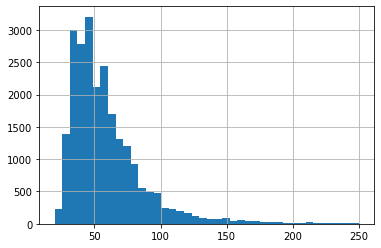

In [68]:
df['total_area'].hist(bins=40,range=(20,250))

Наибольшее количество квартир с площадью от 40 до 50

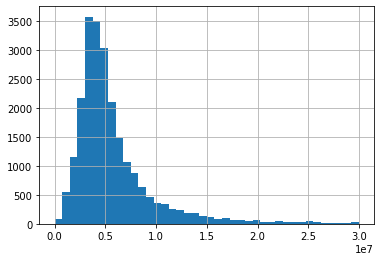

In [69]:
df['last_price'].hist(bins=40,range=(0,3e7))

Наибольшее количество квартир стоят приблизительно 3000000

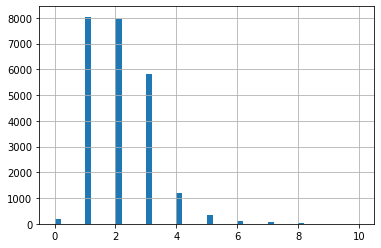

In [70]:
df['rooms'].hist(bins=50,range=(0,10))

Наибольшее количество квартир c 1 или 2 комнатами

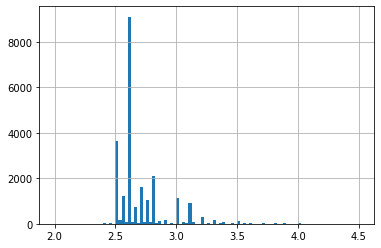

In [71]:
df['ceiling_height'].hist(bins=100,range=(2,4.5))

Наибольшее количество квартир c высотой потолка 2.6

**Исследование времени продажи квартиры**

Заполним пропуски, чтобы можно было столбец привести к целочисленному типу

In [72]:
df['days_exposition'] = df['days_exposition'].fillna(-1)
df['days_exposition'] = df['days_exposition'].astype(int)

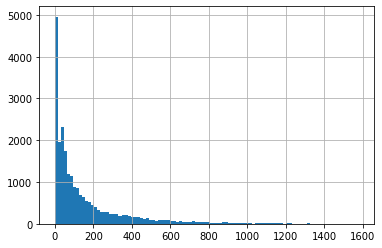

In [73]:
df['days_exposition'].hist(bins=100)

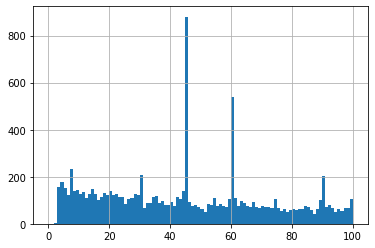

In [74]:
df.loc[df['days_exposition'].notna()]['days_exposition'].hist(bins=100,range=(0,100))

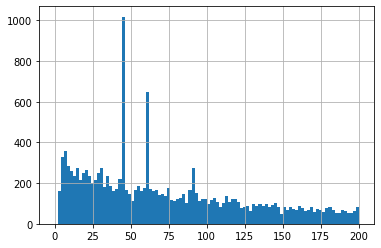

In [75]:
df['days_exposition'].hist(bins=100,range=(0,200))

In [76]:
df['days_exposition'].value_counts()

-1       3181
 45       880
 60       538
 7        234
 30       208
         ... 
 807        1
 871        1
 951        1
 999        1
 1223       1
Name: days_exposition, Length: 1142, dtype: int64

Данные распредлены неравномерно, анамально частые значения 45 и 60. Отфильтруем данные значения, а также пропуски которые заменялись -1

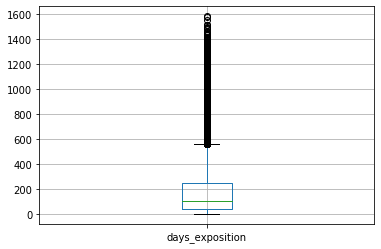

In [77]:
days_exposition_filtred = df.query('days_exposition != 45 and days_exposition != 60 and days_exposition != -1')
days_exposition_filtred.boxplot('days_exposition')

In [78]:
days_exposition_filtred['days_exposition'].describe()

count    19100.000000
mean       190.554607
std        224.742146
min          1.000000
25%         42.000000
50%        108.000000
75%        249.000000
max       1580.000000
Name: days_exposition, dtype: float64

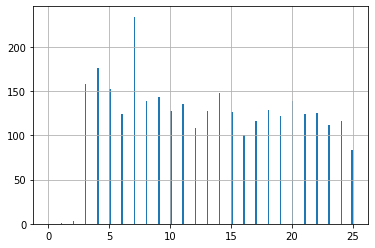

In [79]:
days_exposition_filtred['days_exposition'].hist(bins=200,range = (0,25))

Среднее время размещения равно 190 дней. Медиана равна 108.
Объявления более 600 дней, можно считать анамально долгими продажами.
Анамально быстрыми продажами можно считать продажи менее чем за 3 дня.

In [80]:
days_exposition_filtred = days_exposition_filtred.query('days_exposition < 600 and days_exposition > 3')

**Поиск анамальных значений по площадям квартир**

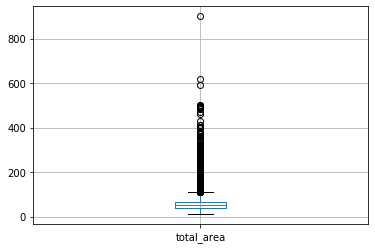

In [81]:
days_exposition_filtred.boxplot('total_area')

Посмотрим как изменится график, если брать только квартиры, расположеные в 5000 м от центра.

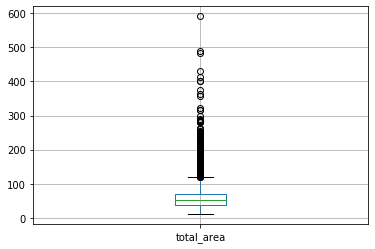

In [82]:
days_exposition_filtred.query('city_сenters_nearest<5000').boxplot('total_area')

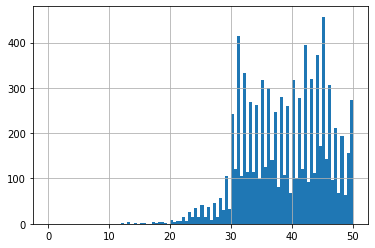

In [83]:
days_exposition_filtred['total_area'].hist(bins=100, range = (0,50))

С учетом этого выбросами будем считать квартиры с площадью > 200 в общее исследование их брать не будем. Аномально маленькие площади < 20.

In [84]:
df_clean = days_exposition_filtred.query('total_area <= 200 and total_area>=20')

**Поиск аномальных значений стоимости квартир**

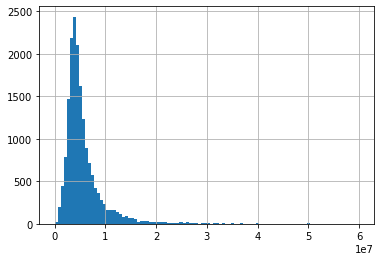

In [85]:
df_clean['last_price'].hist(bins = 100,range=(0,6e7))

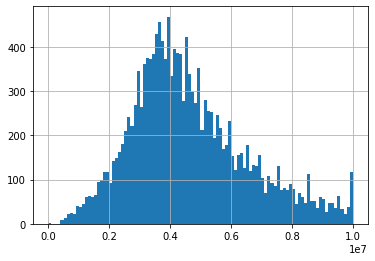

In [86]:
df_clean['last_price'].hist(bins = 100,range=(0,1e7))

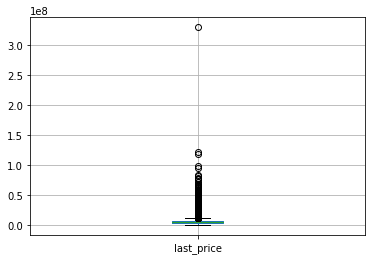

In [87]:
df_clean.boxplot('last_price')

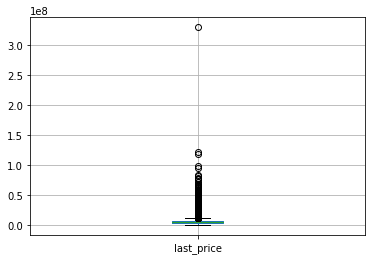

In [88]:
df_clean.boxplot('last_price')

In [89]:
df_clean['last_price'].describe()

count    1.756800e+04
mean     5.795129e+06
std      5.702922e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.500000e+06
75%      6.450000e+06
max      3.300000e+08
Name: last_price, dtype: float64

In [90]:
q1 =  df['last_price'].quantile(0.25)
q3 = df['last_price'].quantile(0.75)
iqr = q3 - q1
min = q1-1.5*iqr
print(min)
max = q3+1.5*iqr

print(max)
df_clean = df_clean.query('last_price > @min and last_price < @max')

-1700000.0
11900000.0


**Поиск аномальных значений по количеству комнат**

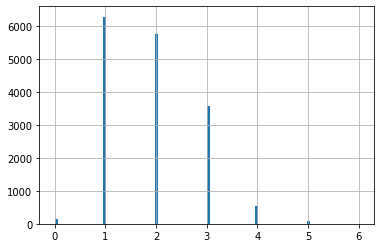

In [91]:
df_clean['rooms'].hist(bins=100)

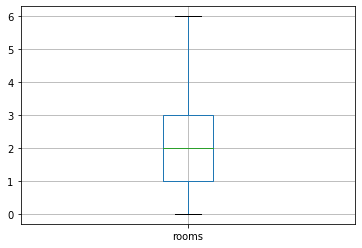

In [92]:
df_clean.boxplot('rooms')

Квартиры с более 6 комнатами можно считать выбросами.

In [93]:
df_clean[df_clean['rooms'] > 6]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,city_сenters_nearest,days_exposition,city_сenters_nearest_cut,living_fraction,kitchen_fraction,price_m_sq,day_of_week_exposition,month_exposition,year_exposition,category_floors


In [94]:
df_clean = df_clean.query('rooms<=6')

**Поиск аномальных значений по высоте потолков**

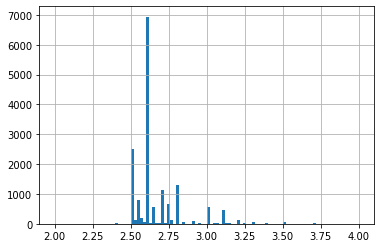

In [95]:
df_clean['ceiling_height'].hist(bins=100,range=(2,4))

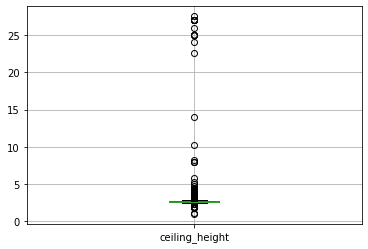

In [96]:
df_clean.boxplot('ceiling_height')

Высоту потолков менее 2.4 м и более 4 м будем считать аномальными значениями

In [97]:
df_clean.query('ceiling_height < 2.4')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,city_сenters_nearest,days_exposition,city_сenters_nearest_cut,living_fraction,kitchen_fraction,price_m_sq,day_of_week_exposition,month_exposition,year_exposition,category_floors
552,11,2999000,33.50,2017-03-30,1,2.00,15,17.500,6,False,...,11746.0,270,"(10000.0, 12000.0]",0.522388,0.194030,89522.39,3,3,2017,Другой
1582,4,4100000,45.60,2016-01-13,2,2.30,9,28.400,8,False,...,14977.0,329,"(12000.0, 15000.0]",0.622807,0.153509,89912.28,2,1,2016,Другой
4212,1,2120000,35.43,2017-12-18,1,2.00,18,16.600,9,False,...,-1.0,36,NaN,0.468529,0.248377,59836.30,0,12,2017,Другой
5498,17,2200000,56.00,2018-04-02,2,2.30,5,45.000,1,False,...,-1.0,55,NaN,0.803571,0.160714,39285.71,0,4,2018,Первый
5712,5,1500000,42.80,2017-08-14,2,1.20,2,27.500,1,False,...,-1.0,248,NaN,0.642523,0.121495,35046.73,0,8,2017,Первый
5850,9,1650000,35.50,2018-05-29,1,2.00,5,19.525,5,False,...,-1.0,100,NaN,0.550000,0.158000,46478.87,1,5,2018,Последний
11352,4,3300000,36.00,2017-06-18,1,2.00,17,15.200,12,False,...,26980.0,53,"(20000.0, 65968.0]",0.422222,0.280556,91666.67,6,6,2017,Другой
16884,0,1500000,33.00,2018-10-03,1,2.00,5,20.000,5,False,...,-1.0,6,NaN,0.606061,0.181818,45454.55,2,10,2018,Последний
16934,5,4100000,40.00,2017-10-17,1,1.75,37,17.400,5,False,...,20444.0,71,"(20000.0, 65968.0]",0.435000,0.208500,102500.00,1,10,2017,Другой
17762,20,2300000,54.30,2018-06-28,3,2.30,5,39.000,2,False,...,-1.0,189,NaN,0.718232,0.097606,42357.27,3,6,2018,Другой


In [98]:
df_clean.query('ceiling_height > 4').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,city_сenters_nearest,days_exposition,city_сenters_nearest_cut,living_fraction,kitchen_fraction,price_m_sq,day_of_week_exposition,month_exposition,year_exposition,category_floors
154,1,8200000,80.0,2018-11-06,3,4.15,3,44.20,2,False,...,3167.0,38,"(0.0, 5000.0]",0.552500,0.152500,102500.00,1,11,2018,Другой
355,17,3600000,55.2,2018-07-12,2,25.00,5,32.00,2,False,...,-1.0,259,NaN,0.579710,0.158000,65217.39,3,7,2018,Другой
1053,13,550000,29.0,2018-02-01,1,5.00,3,15.95,1,False,...,-1.0,6,NaN,0.550000,0.158000,18965.52,3,2,2018,Первый
1129,20,6695000,36.9,2018-09-28,1,4.06,5,22.00,2,False,...,2990.0,110,"(0.0, 5000.0]",0.596206,0.195122,181436.31,4,9,2018,Другой
2999,11,4450000,36.0,2017-12-12,1,4.19,5,18.00,1,False,...,4256.0,78,"(0.0, 5000.0]",0.500000,0.222222,123611.11,1,12,2017,Первый


In [99]:
df_clean = df_clean.query('ceiling_height <= 4 and ceiling_height>= 2.4')

**Вывод:** Из данных были исключены некоторые аномальные значения: 
- высота потолка  менее 2.4 или более 4
- квартиры с количеством комнат более 6
- квартиры дороже 11900000
- квартиры с площадью более 200 или менее 20
- объявления, которые размещались менее 3 дней или более 600

**Факторы, влияющие на цены**

In [100]:
df_clean['price_m_sq'] = df_clean['price_m_sq'].astype('float')
pivot_df = pd.pivot_table(df_clean,values='price_m_sq',index='rooms',aggfunc=['mean','median'])
pivot_df

,mean,median
,price_m_sq,price_m_sq
rooms,,
0,108305.220800,105334.465
1,99550.839885,99971.430
2,90522.197948,91123.475
3,83309.090227,84858.570
4,80365.744390,81032.410
5,74799.544384,74803.150
6,72732.926667,75558.480


Зависимость стоимости квадратного метра от общей площади

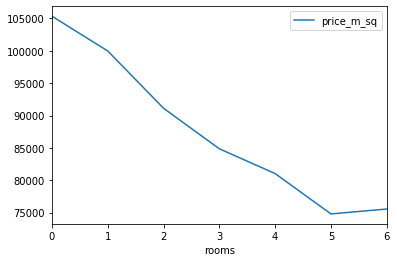

In [101]:
pivot_df['median'].plot()

In [102]:
pivot_df = pd.pivot_table(df_clean,values='price_m_sq',index='category_floors',aggfunc=['mean','median'])
pivot_df

,mean,median
,price_m_sq,price_m_sq
category_floors,,
Другой,95746.240688,95434.78
Первый,78974.051139,80260.30
Последний,84323.226868,85778.78


С увеличением колчества комнат, стоимость квадратного метра уменьшается.

Зависимость стоимости квадратного метра от категории этажа

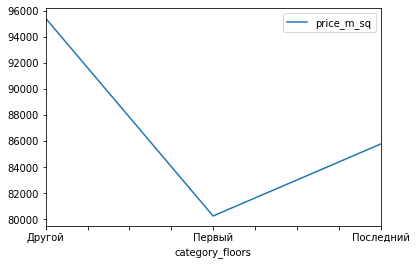

In [103]:
pivot_df['median'].plot()

Тип этажа имеет влияние на стоимость квартиры, самая низкая стоимость квадратного метра у квартир на 1 этаже. Самые дорогие квартиры не на первом и не на последнем этаже.

In [104]:
df_clean = df_clean.query('city_сenters_nearest != -1')
pivot_df = pd.pivot_table(df_clean,values='price_m_sq',index='city_сenters_nearest_cut',aggfunc=['mean','median','max','min'])
pivot_df

,mean,median,max,min
,price_m_sq,price_m_sq,price_m_sq,price_m_sq
city_сenters_nearest_cut,,,,
"(0.0, 5000.0]",113843.745964,108064.520,262711.86,15861.57
"(5000.0, 10000.0]",112668.698399,107865.170,276000.00,111.83
"(10000.0, 12000.0]",103928.477032,101724.140,216015.62,54098.36
"(12000.0, 15000.0]",104101.823329,101789.710,248484.85,24439.92
"(15000.0, 20000.0]",96395.089270,95168.215,170648.46,42857.14
"(20000.0, 65968.0]",83585.737535,81081.080,166666.67,41025.64


Зависимость стоимости квадратного метра от удаленнойсти от центра

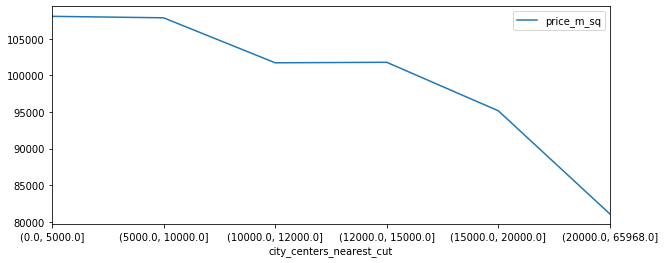

In [105]:
pivot_df['median'].plot(figsize = (10,4))

In [106]:
df_clean.groupby('city_сenters_nearest_cut')['price_m_sq'].quantile(0.25)

city_сenters_nearest_cut
(0.0, 5000.0]         92289.720
(5000.0, 10000.0]     94178.225
(10000.0, 12000.0]    90113.085
(12000.0, 15000.0]    90322.580
(15000.0, 20000.0]    83920.940
(20000.0, 65968.0]    70926.110
Name: price_m_sq, dtype: float64

In [107]:
df_clean.groupby('city_сenters_nearest_cut')['price_m_sq'].quantile(0.75)

city_сenters_nearest_cut
(0.0, 5000.0]         130081.300
(5000.0, 10000.0]     128481.315
(10000.0, 12000.0]    114516.130
(12000.0, 15000.0]    115634.220
(15000.0, 20000.0]    107142.860
(20000.0, 65968.0]     93447.720
Name: price_m_sq, dtype: float64

Аномальными можно считать стоимость более 131000 или менее 71 000 за квадратный метр.

При удалении от центра, стоимость за квдаратный метр уменьшается.

**Поиск 10 населенных пунктов с наибольшим количеством объявлений**

In [108]:
df_clean['locality_name'].unique()

array(['посёлок Шушары', 'Санкт-Петербург', 'посёлок Парголово',
       'Ломоносов', 'Петергоф', 'Пушкин', 'Колпино', 'Кронштадт',
       'посёлок Металлострой', 'Павловск', 'Сестрорецк', 'Красное Село',
       'посёлок Понтонный', 'Зеленогорск', 'посёлок Стрельна',
       'Неизвестно', 'посёлок Песочный', 'посёлок Петро-Славянка',
       'посёлок Сапёрный', 'посёлок Щеглово', 'посёлок Молодёжное',
       'посёлок Репино', 'поселок Лисий Нос', 'посёлок Левашово',
       'поселок Мурино', 'посёлок Усть-Ижора'], dtype=object)

В столбце встречаются неявные дубли, иногда указывается поселок, а иногда посёлок.

Сделаем везде замену на ё:

In [109]:
df['locality_name'] = df['locality_name'].str.replace('поселок', 'посёлок')
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'посёлок Молодцово',
       'посёлок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'посёлок Торковичи', 'посёлок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет

Посмотри список ТОП-10 населенных пунктов для таблицы исходной и очищенной от аномальных значений.

In [110]:
df['locality_name'].value_counts().head(10)

Санкт-Петербург      15721
посёлок Мурино         556
посёлок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: locality_name, dtype: int64

In [111]:
df_clean['locality_name'].value_counts().head(10)

Санкт-Петербург      10632
посёлок Шушары         352
Колпино                260
посёлок Парголово      252
Пушкин                 250
Петергоф               148
Красное Село           137
Сестрорецк             130
Ломоносов               93
Кронштадт               74
Name: locality_name, dtype: int64

Когда исключили аномальные значения, ТОП не изменился, при этом большинство строк удалены именно в Санкт-Петербурге. Большинство всех объявлений по Санкт-Петербургу.

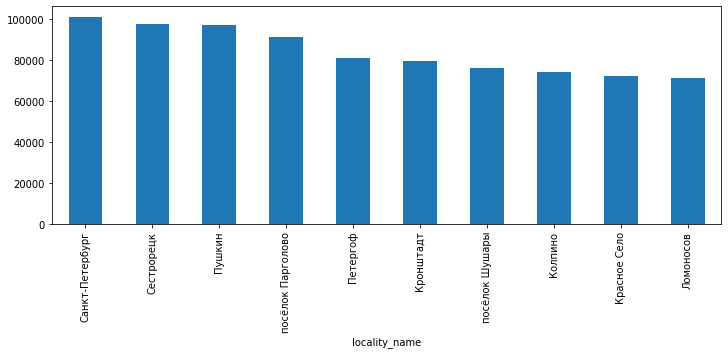

In [112]:
list_locality = df_clean['locality_name'].value_counts().head(10).index
df_locality = df_clean.query('locality_name in @list_locality').groupby(by='locality_name')['price_m_sq'].median()
df_locality.sort_values(ascending = False).plot.bar(figsize = (12,4))

В Санкт-Петербурге самые дорогие квартиры. Наименьшая стоимость квадратного метра из 10 популярных в Выборге.

**Зависимость стоимости квадратного метра от времени размещения**

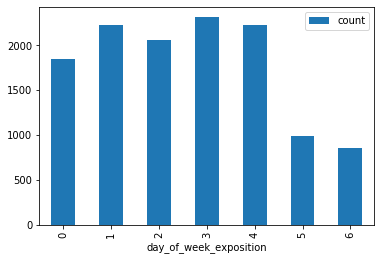

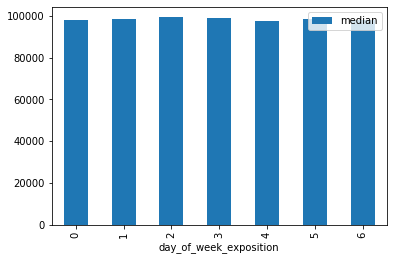

In [113]:
df_clean.groupby(by='day_of_week_exposition')['price_m_sq'].agg(['count']).plot.bar()
df_clean.groupby(by='day_of_week_exposition')['price_m_sq'].agg(['median']).plot.bar()

По выходным, объявлений размещают приблизительно в 2 раза меньше, чем в рабочие дни. При это стоимость квадратного метра не зависит от того, в какой день было размещено объявление.

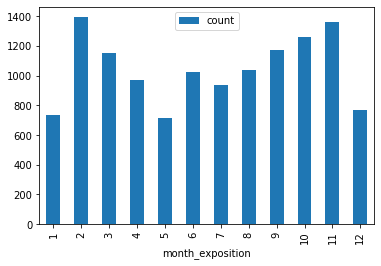

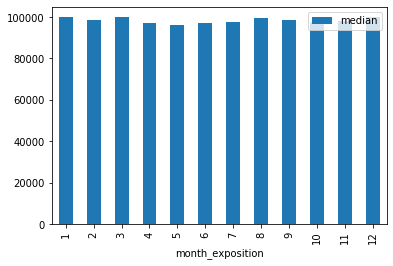

In [114]:
df_clean.groupby(by='month_exposition')['price_m_sq'].agg(['count']).plot.bar()
df_clean.groupby(by='month_exposition')['price_m_sq'].agg(['median']).plot.bar()

Меньше всего объявлений размещают, в январе, мае и декабре, видимо это связано с количеством праздничных дней в эти месяцы. При этом стоимость квдартного метра существенно не меняется в зависимости от месяца.

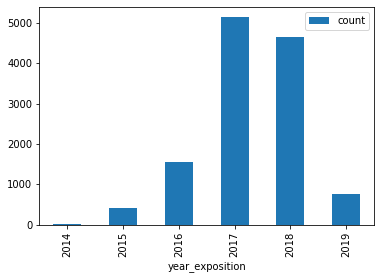

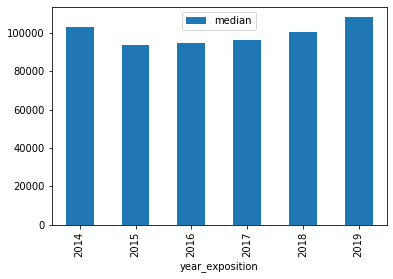

In [115]:
df_clean.groupby(by='year_exposition')['price_m_sq'].agg(['count']).plot.bar()
df_clean.groupby(by='year_exposition')['price_m_sq'].agg(['median']).plot.bar()

Большинство объявлений было размещено в 2017, 2018 годы. При этом в 2019 стоимость квадратного метра выросла.

In [116]:
df_clean.groupby(by='year_exposition')['price_m_sq'].agg(['median'])

,median
year_exposition,
2014,102996.250
2015,93531.260
2016,94761.785
2017,96226.420
2018,100663.370
2019,108110.990


**Исследование стоимости квадратного метра в центра Санкт-Петербурга**

Создадим столбец с километрами до центра

In [117]:
df_clean_spb = df_clean.query('locality_name == "Санкт-Петербург"')

In [118]:
df_clean_spb['city_сenters_km'] = (df_clean_spb['city_сenters_nearest']/1000).round()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [119]:
df_clean_spb['city_сenters_km'].astype(int)

2        14
4         8
9        15
10       14
15       14
         ..
23687    17
23688    14
23689    16
23690     6
23691     4
Name: city_сenters_km, Length: 10632, dtype: int64

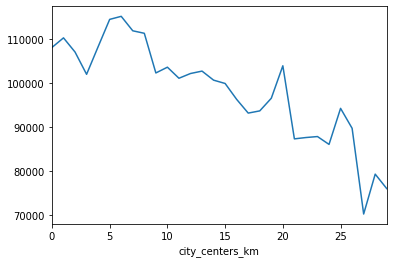

In [120]:
df_clean_spb.groupby(by='city_сenters_km')['price_m_sq'].median().plot.line()

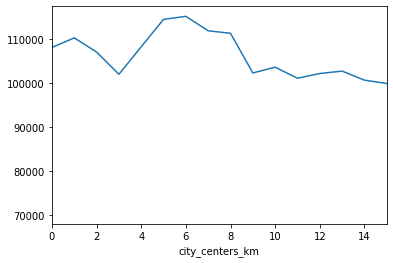

In [121]:
df_clean_spb.groupby(by='city_сenters_km')['price_m_sq'].median().plot.line(xlim = (0,15))

В центре квартиры дороже, центром можно считать область в 8 км.

**Исследование квартир в центре**

In [122]:
df_clean_spb['is_center'] = df_clean_spb['city_сenters_km'] < 8

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [123]:
pd.pivot_table(df_clean_spb,values = ['total_area', 'price_m_sq', 'rooms', 'ceiling_height'],aggfunc ='median',index='is_center')

,ceiling_height,price_m_sq,rooms,total_area
is_center,,,,
False,2.6,100000.00,2,47.0
True,3.0,110999.42,2,64.0


В центре Санкт_Петербурга, у квартир выше потолки, стоимость квадратного метра выше в среднем на 11 тысяч. Средняя площадь квартир в центре больше.

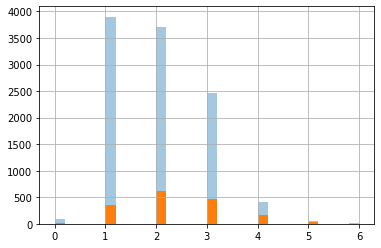

In [124]:
df_clean_spb['rooms'].hist(bins=30,alpha = 0.4)
df_clean_spb[df_clean_spb['is_center']]['rooms'].hist(bins=30)

Большинство пятикомнатных квартир, которые есть в Санкт-Петербурге, находятся в центре. В центре двухкомнатных квартир больше всего, в то время как по Санкт-Петербургу, больше всего однокомнатных квартир.

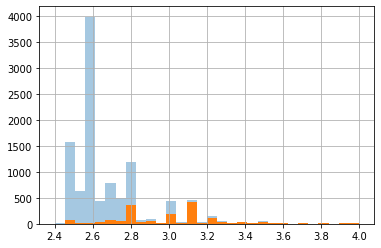

In [125]:
df_clean_spb['ceiling_height'].hist(bins=30,alpha = 0.4)
df_clean_spb[df_clean_spb['is_center']]['ceiling_height'].hist(bins=30)

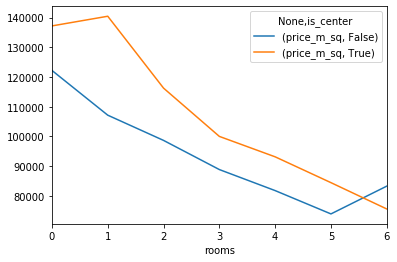

In [126]:
pd.pivot_table(df_clean_spb,values = ['price_m_sq'],columns=['is_center'],aggfunc ='median',index='rooms').plot.line()

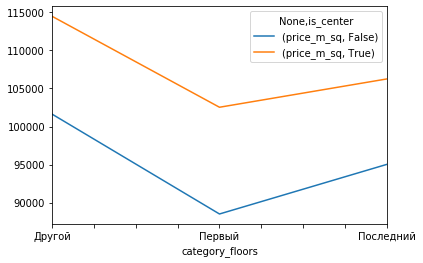

In [127]:
pd.pivot_table(df_clean_spb,values = ['price_m_sq'],columns=['is_center'],aggfunc ='median',index='category_floors').plot.line()

Тип этажа, в центре города, имеет такое же влияние на стоимость, как и не в центре.

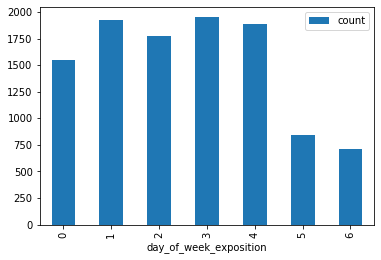

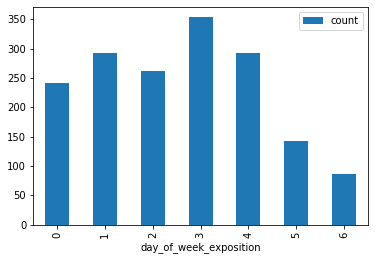

In [128]:
df_clean_spb.groupby(by='day_of_week_exposition')['price_m_sq'].agg(['count']).plot.bar()
df_clean_spb[df_clean_spb['is_center']].groupby(by='day_of_week_exposition')['price_m_sq'].agg(['count']).plot.bar()

Объявления о квартирах в центре города размещаются менее равномерно в течение недели. Значительно чаще объявления выкладывают в четверг.

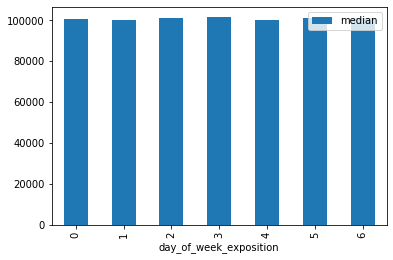

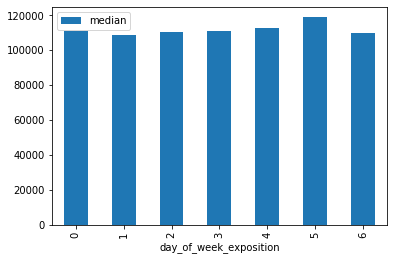

In [129]:
df_clean_spb.groupby(by='day_of_week_exposition')['price_m_sq'].agg(['median']).plot.bar()
df_clean_spb[df_clean_spb['is_center']].groupby(by='day_of_week_exposition')['price_m_sq'].agg(['median']).plot.bar()

Объявления в понедельник и в четверг с более дорогими квартирами в центре.

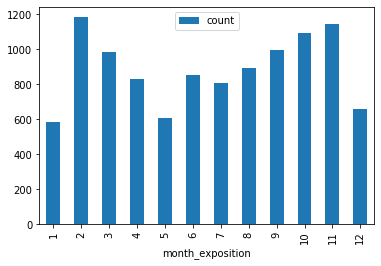

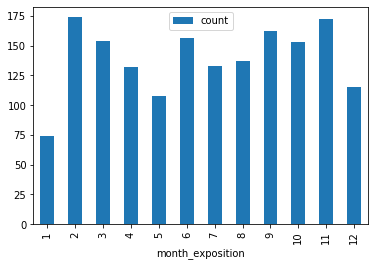

In [130]:
df_clean_spb.groupby(by='month_exposition')['price_m_sq'].agg(['count']).plot.bar()
df_clean_spb[df_clean_spb['is_center']].groupby(by='month_exposition')['price_m_sq'].agg(['count']).plot.bar()

В целом по городу количество объявлений в течение года равномерно убывыает с февраля по май, в июне постепенно возрастает до ноября. В то время как в центре количество объявлений имеют другую тенденцию по месяцам. Месяцы, когда наибольшее количество объявлений Февраль, март, июнь, сентябрь, ноябрь.

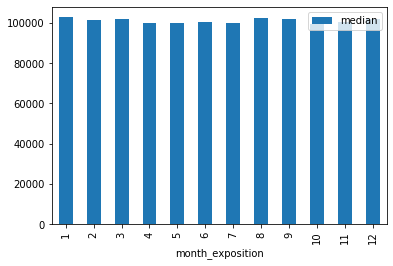

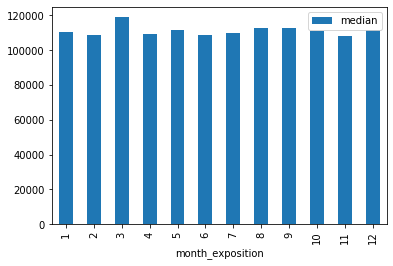

In [131]:
df_clean_spb.groupby(by='month_exposition')['price_m_sq'].agg(['median']).plot.bar()
df_clean_spb[df_clean_spb['is_center']].groupby(by='month_exposition')['price_m_sq'].agg(['median']).plot.bar()

В центре города, существенно выделяется цена у объявлений опубликованных в марте.

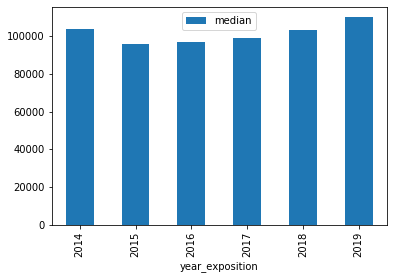

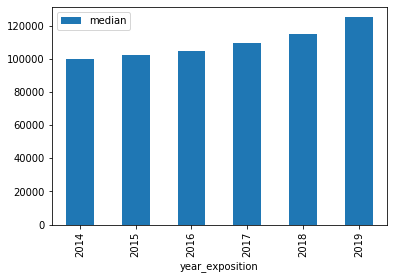

In [132]:
df_clean_spb.groupby(by='year_exposition')['price_m_sq'].agg(['median']).plot.bar()
df_clean_spb[df_clean_spb['is_center']].groupby(by='year_exposition')['price_m_sq'].agg(['median']).plot.bar()

**Выввод:**

Был проведен иследовательский анализ объявлений недвижимости.
- был определена область центра Санкт-Петербурга 8 км, стоимость квадратного метра в этой области значительно выше. Потолки в квартирах в среднем выше и чаще всего не менее 3 м. Квартиры имеют большую площадь, с тем же количеством комнат. В центре объявления размещаются часто в течение всего года, при этом в месяцы с праздниками, объявлений меньше как в целом по всей области.
- в незавивисимости на сколько удалена квартира от центра, цена на первом этаже всегда ниже, чем на любом другом. На последнем этаже, квартиры дешевле любых других выше 1.
- подавляющее большинство всех объявлений из Санкт-Петербурга
- для всех квартир характерно, что с увеличением количества комнат и площади, стоимость квадратного метра уменьшается

## Общий вывод

Было проведено исследование объявлений о недвижимости в Ленинградской области

- Данные содержали много пропусков и сильно зашумлены аномальными значениями
- Для более точно анализа в дальнейшем, рекомендуется доработать техническую реализацию источников данных, например требовать обязательного заполнения всей информации по квартире. А также скорректировать автоматические вычисление геоданных и получать точные координаты дома.

Выявлены следующие параметры, которые можно считать аномальными в объявлениях:
- высота потолков более 5 м
- жилая площадь менее 18 м
- количество комнат более 7
- площадь квартиры более 200 или менее 20
- объявляения размещаемые более 600 дней или менее 3 дней
- есть аномальное увелечение количества объявлений размещаемых 45 и 60 дней, но возможно это связано с модерацией в системе через полтора и 2 месяца.
- стоимость квартир боле 120 000 000
- стоимость квадратного метра более 131 000 или менее 71 000
- стоимость квадратного метра, на этаже выше первого и ниже последнего, равна или меньше стоимости квартиры на 1 или последнем этаже, в том же доме